In [25]:
# Copyright 2025 The LEVER Authors - All rights reserved.
# SPDX-License-Identifier: Apache-2.0

"""
Unified visualization configuration for publication-quality plots.
High-contrast, colorblind-friendly palette with consistent styling.
"""

import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.ticker as ticker

# ============================================================================
# Visual Style Configuration
# ============================================================================

# Scientific color palette optimized for contrast and accessibility
PALETTE = {
    'baseline':   '#E29578',  # Coral (reference methods)
    'primary':    '#264653',  # Charcoal (main results)
    'secondary':  '#2A9D8F',  # Teal (optimization/iterative)
    'accent':     '#457B9D',  # Slate blue (comparison/exact)
    'bar_fill':   '#E9ECEF',  # Light gray bars
    'bar_edge':   '#6C757D',  # Slate gray edges
    'grid':       '#E5E5E5',  # Subtle grid lines
    'text':       '#333333'   # Dark text
}

def apply_style():
    """Configure global matplotlib settings for academic publication quality."""
    rcParams.update({
        'font.family': 'sans-serif',
        'font.sans-serif': ['Arial', 'Helvetica', 'DejaVu Sans'],
        'font.size': 11,
        'axes.linewidth': 1.2,
        'axes.edgecolor': PALETTE['text'],
        'axes.labelcolor': PALETTE['text'],
        'axes.spines.top': False,
        'axes.spines.right': False,
        'xtick.color': PALETTE['text'],
        'ytick.color': PALETTE['text'],
        'text.color': PALETTE['text'],
        'figure.dpi': 300,
        'savefig.dpi': 300,
        'grid.color': PALETTE['grid'],
        'grid.linestyle': '--',
        'grid.alpha': 0.7,
        'legend.frameon': False,
        'legend.fontsize': 10,
    })

def format_axis(ax, xlabel=None, ylabel=None, grid=True, log_scale=False):
    """
    Standardize axis formatting with scientific notation.
    
    Args:
        ax: Matplotlib axis object
        xlabel: X-axis label
        ylabel: Y-axis label  
        grid: Enable grid
        log_scale: Use scientific notation for log axes
    """
    if xlabel: 
        ax.set_xlabel(xlabel, labelpad=8, fontweight='medium')
    if ylabel:
        ax.set_ylabel(ylabel, labelpad=8, fontweight='medium')
    
    if grid:
        ax.grid(True, zorder=0)
    
    # Scientific notation for log scales, plain for linear
    if log_scale:
        ax.yaxis.set_major_formatter(ticker.LogFormatterSciNotation())
    else:
        ax.yaxis.set_major_formatter(ticker.ScalarFormatter(useOffset=False))

# Apply global style
apply_style()


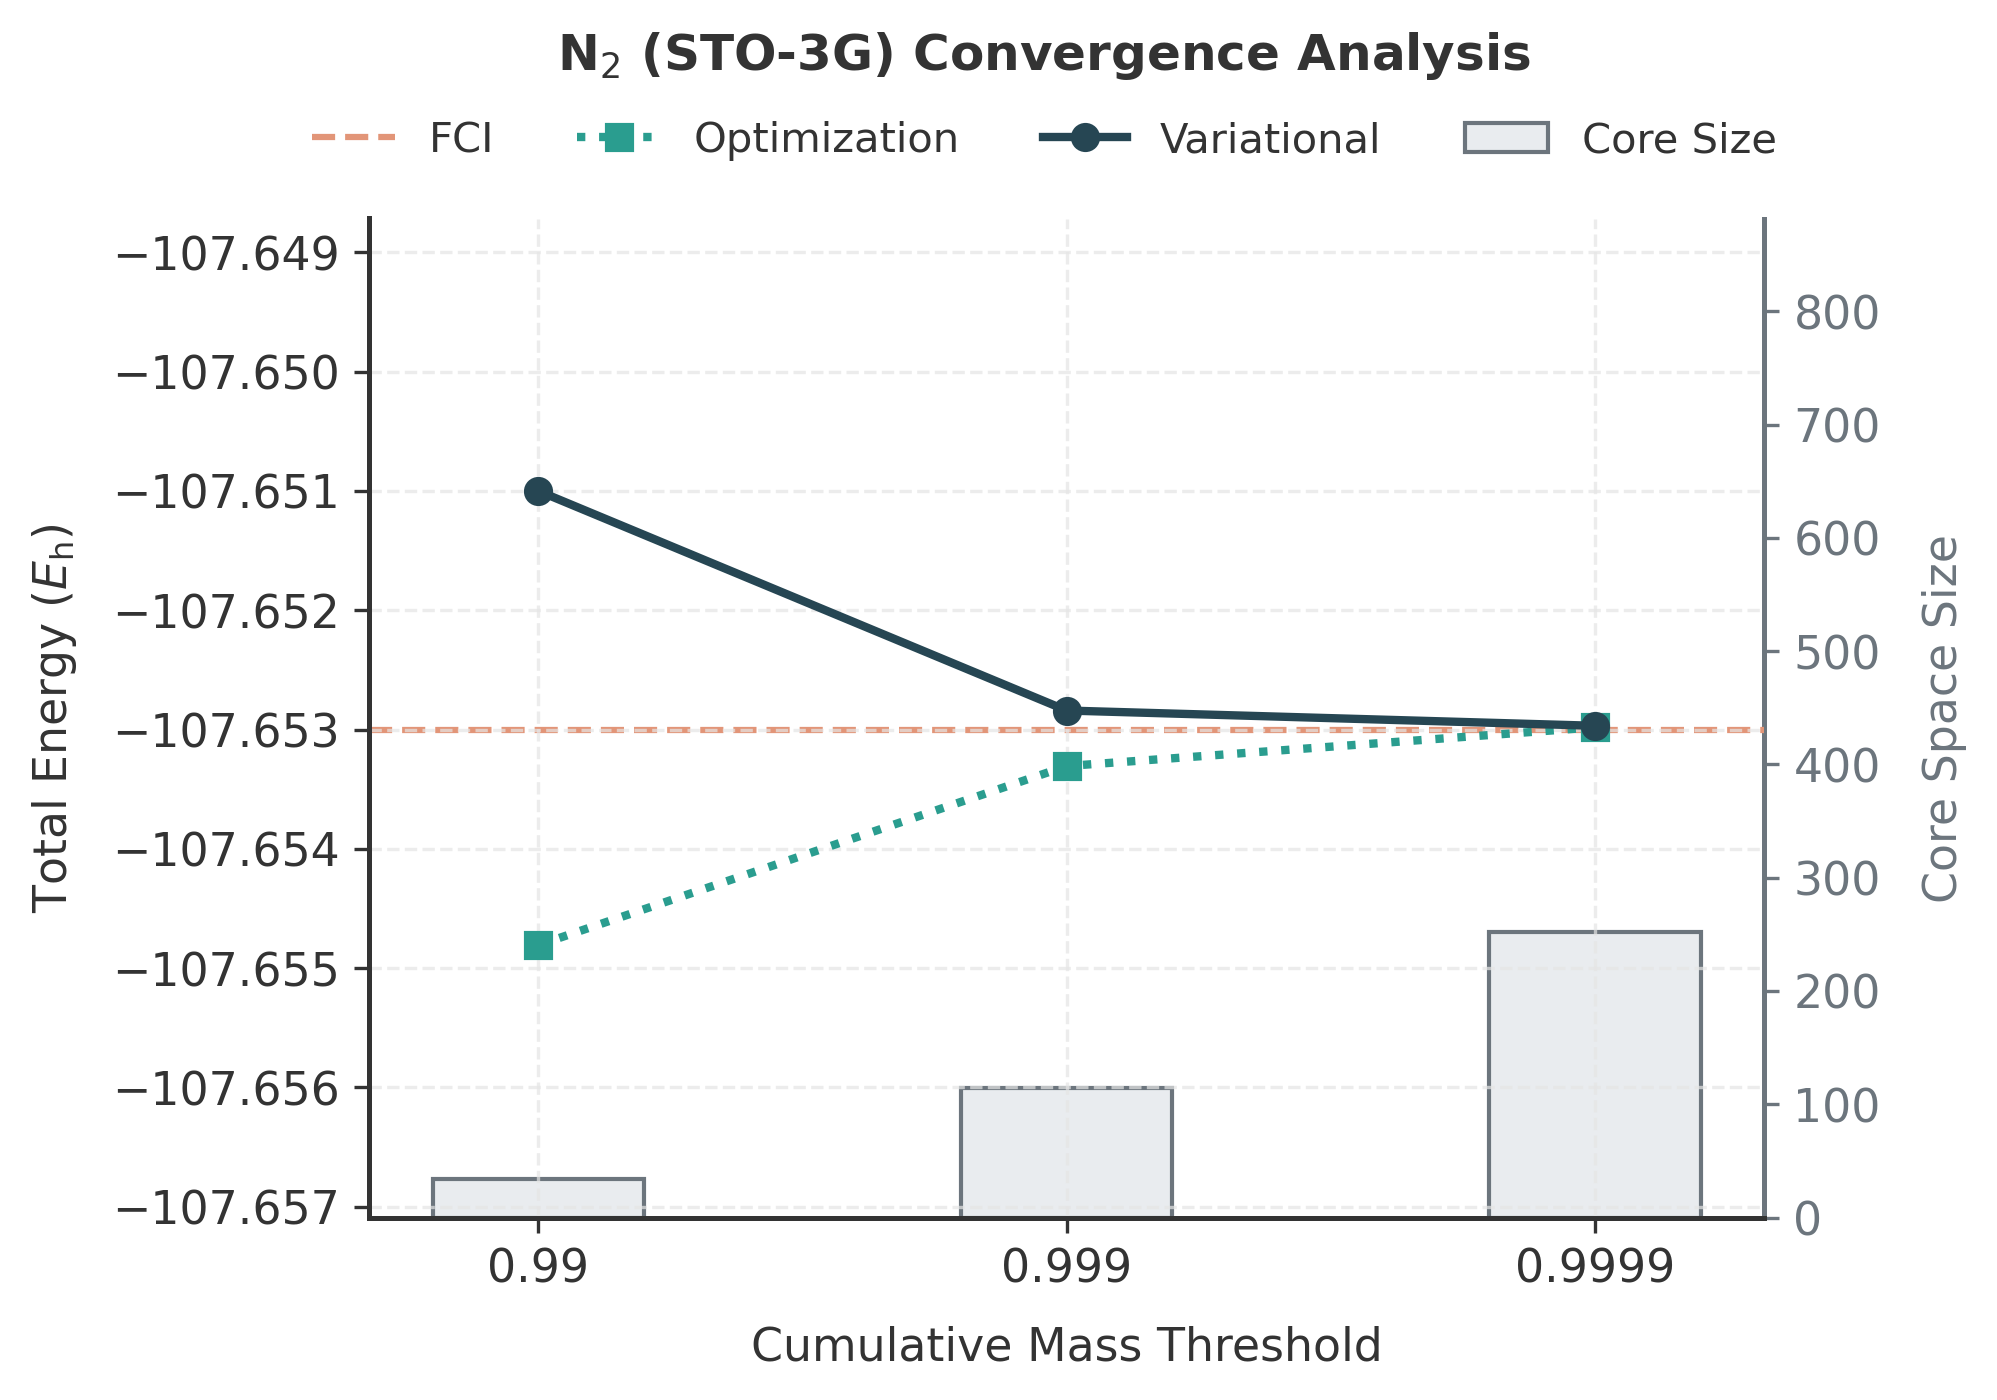

In [26]:
# Copyright 2025 The LEVER Authors - All rights reserved.
# SPDX-License-Identifier: Apache-2.0

"""
Experiment 1: N2/STO-3G convergence analysis.
Dual-axis plot showing energy convergence vs core space size.
"""

import pandas as pd
import matplotlib.pyplot as plt

def plot_n2_convergence():
    """Plot N2 convergence with core space size bars."""
    # Experimental data
    data = {
        "Mass": ["0.99", "0.999", "0.9999"],
        "E_Opt": [-107.6548065, -107.6533061, -107.6529815],
        "E_Var": [-107.6510004, -107.6528407, -107.6529687], 
        "CoreSize": [34, 114, 252],
        "E_FCI": -107.6529999
    }
    df = pd.DataFrame(data)
    x_pos = range(len(df))

    # Create dual-axis plot
    fig, ax1 = plt.subplots(figsize=(6, 4.5))
    plt.subplots_adjust(top=0.85)

    # Right axis: core space size (bars)
    ax2 = ax1.twinx()
    ax2.bar(x_pos, df["CoreSize"], color=PALETTE['bar_fill'], 
            edgecolor=PALETTE['bar_edge'], width=0.4, zorder=0, 
            label="Core Size")
    
    ax2.set_ylabel("Core Space Size", color=PALETTE['bar_edge'], labelpad=10)
    ax2.tick_params(axis='y', colors=PALETTE['bar_edge'])
    ax2.spines['right'].set_visible(True)
    ax2.spines['right'].set_color(PALETTE['bar_edge'])
    ax2.set_ylim(0, df["CoreSize"].max() * 3.5)

    # Left axis: energy convergence (lines)
    ax1.set_zorder(ax2.get_zorder() + 1)
    ax1.patch.set_visible(False)
    
    # Reference and method lines
    l_ref = ax1.axhline(data["E_FCI"], color=PALETTE['baseline'], 
                        linestyle='--', linewidth=1.5, label="FCI", zorder=1)
    l_opt, = ax1.plot(x_pos, df["E_Opt"], marker='s', linestyle=':', 
                      color=PALETTE['secondary'], markersize=6, linewidth=2, 
                      label="Optimization", zorder=2)
    l_var, = ax1.plot(x_pos, df["E_Var"], marker='o', linestyle='-', 
                      color=PALETTE['primary'], markersize=6, linewidth=2, 
                      label="Variational", zorder=3)

    # Axis formatting
    format_axis(ax1, "Cumulative Mass Threshold", r"Total Energy ($E_{\mathrm{h}}$)")
    ax1.set_xticks(x_pos)
    ax1.set_xticklabels(df["Mass"])

    # Energy axis scaling
    e_vals = df["E_Opt"].tolist() + df["E_Var"].tolist()
    margin = (max(e_vals) - min(e_vals)) * 0.6
    ax1.set_ylim(min(e_vals) - margin, max(e_vals) + margin)

    # Unified legend
    fig.legend([l_ref, l_opt, l_var, ax2.patches[0]], 
               ["FCI", "Optimization", "Variational", "Core Size"], 
               loc='upper center', bbox_to_anchor=(0.5, 0.95), ncol=4)
    
    fig.suptitle(r"N$_2$ (STO-3G) Convergence Analysis", y=0.99, 
                 fontsize=12, weight='bold')
    plt.show()

plot_n2_convergence()


Computing FCI reference (14400 determinants)...
  |S|    |C|     Error (mHa)
                  sCI   Löwdin
----------------------------------------
   10   3396   60.198    3.739
   50   7154   13.000    0.205
  100   9718    4.043    0.040
  150  11083    1.710    0.098
  200  11694    0.937    0.054
  400  13025    0.105    0.004
  800  13410    0.006    0.000


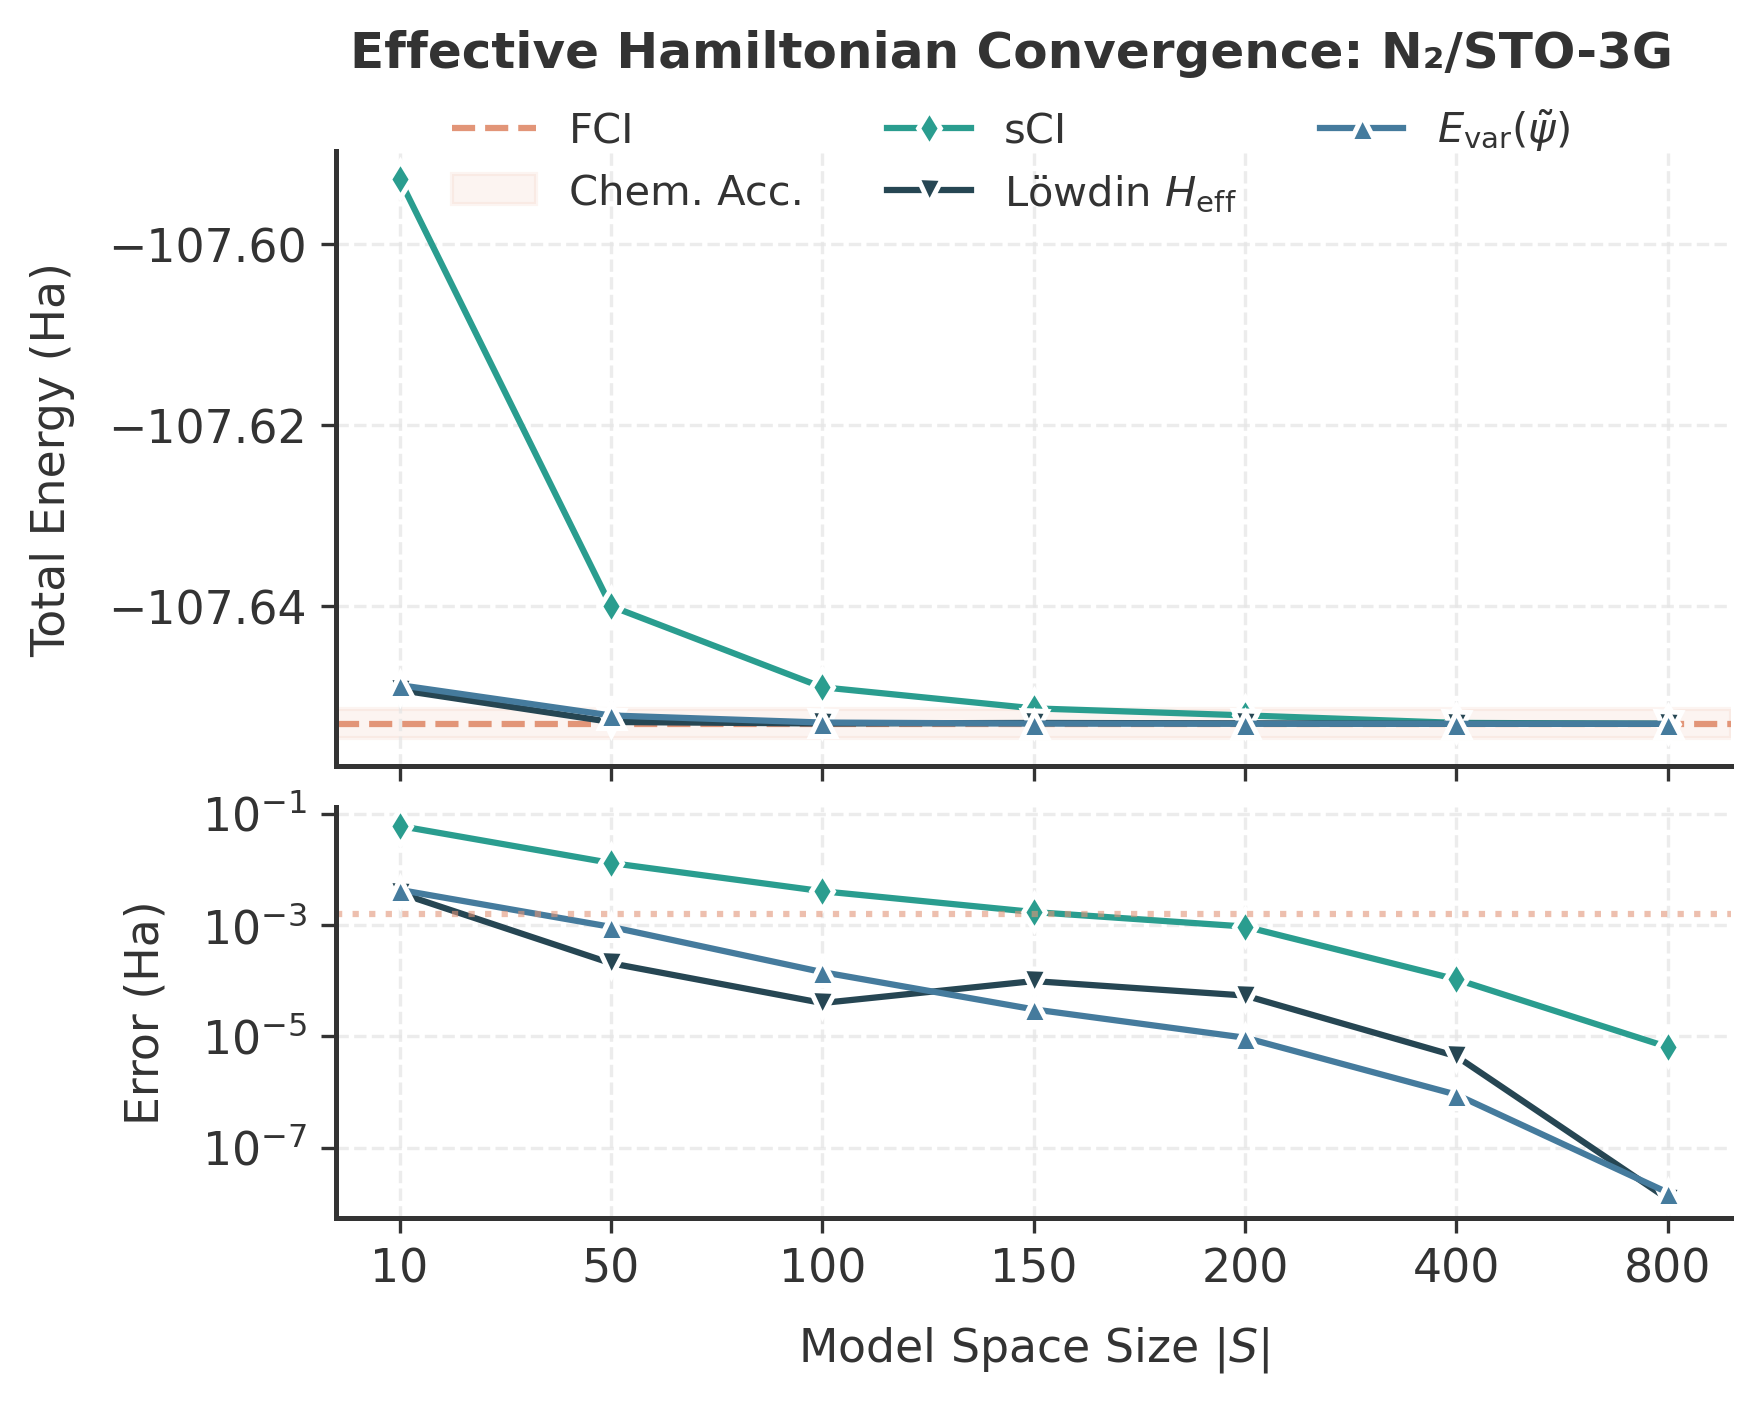

In [27]:
# Copyright 2025 The LEVER Authors - All rights reserved.
# SPDX-License-Identifier: Apache-2.0

"""
Experiment 2: Löwdin effective Hamiltonian convergence study.
Compares sCI, Löwdin, and exact variational energies.
"""

from __future__ import annotations
from dataclasses import dataclass, field
from pathlib import Path
from typing import NamedTuple
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import matplotlib.pyplot as plt
import lever

# Experiment configuration
CFG = {
    "sys_name": "N₂/STO-3G",
    "path": Path("../benchmark/FCIDUMP/N2_sto3g.FCIDUMP"),
    "n_orb": 10,
    "n_elec": (7, 7),
    "k_steps": [10, 50, 100, 150, 200, 400, 800],
    "eps": 1e-12
}

# Shared line style for consistent plotting
LINE_STYLE = {
    'markersize': 6, 
    'linewidth': 1.5, 
    'markeredgecolor': 'white', 
    'markeredgewidth': 1.2
}

@dataclass
class StudyResults:
    """Container for convergence study results."""
    k: list[int] = field(default_factory=list)
    E_sCI: list[float] = field(default_factory=list)
    E_Lowdin: list[float] = field(default_factory=list)
    E_Exact: list[float] = field(default_factory=list)

    def add(self, k, sCI, Lowdin, Exact):
        """Add results for given model space size."""
        self.k.append(k)
        self.E_sCI.append(sCI)
        self.E_Lowdin.append(Lowdin)
        self.E_Exact.append(Exact)

def solve_lowest_eigenpair(H: sp.csr_matrix) -> tuple[float, np.ndarray]:
    """Solve for lowest eigenpair using appropriate solver."""
    if H.shape[0] == 0: 
        return np.inf, np.array([])
    
    # Dense solver for small matrices, sparse for larger ones
    if H.shape[0] < 10:
        evals, evecs = np.linalg.eigh(H.toarray())
        return evals[0], evecs[:, 0]
    else:
        evals, evecs = spla.eigsh(H, k=1, which="SA", tol=1e-15, maxiter=3000)
        return evals[0], evecs[:, 0]

def compute_exact_energy(ψ_tilde: np.ndarray, space, int_ctx) -> float:
    """Compute <ψ|H|ψ> expectation in full T-space."""
    T_dets = np.vstack([space.s_dets, space.c_dets])
    ham_tt, _ = lever.engine.hamiltonian.get_ham_ss(T_dets, int_ctx, CFG['n_orb'])
    H_TT = sp.coo_matrix((ham_tt.vals, (ham_tt.rows, ham_tt.cols)), 
                         shape=ham_tt.shape).tocsr()
    return float(np.real(np.vdot(ψ_tilde, H_TT @ ψ_tilde) / np.vdot(ψ_tilde, ψ_tilde)))

def run_lowdin_convergence():
    """Execute Löwdin convergence study."""
    if not CFG['path'].exists():
        raise FileNotFoundError("FCIDUMP not found")

    # Initialize system and compute FCI reference
    int_ctx = lever.IntCtx(str(CFG['path']), CFG['n_orb'])
    fci_dets = lever.gen_fci_dets(CFG['n_orb'], *CFG['n_elec'])
    E_nuc = int_ctx.get_e_nuc()
    
    print(f"Computing FCI reference ({len(fci_dets)} determinants)...")
    ham_fci, _ = lever.engine.hamiltonian.get_ham_ss(fci_dets, int_ctx, CFG['n_orb'])
    
    # Helper for LEVER COO → SciPy CSR conversion
    to_scipy = lambda op: sp.coo_matrix((op.vals, (op.rows, op.cols)), 
                                       shape=op.shape).tocsr()
    
    E_fci, ψ_fci = solve_lowest_eigenpair(to_scipy(ham_fci))
    E_fci += E_nuc
    
    # Rank determinants by FCI weight for screening
    ranking = np.argsort(-np.abs(ψ_fci))
    
    # Iterative convergence study
    results = StudyResults()
    valid_k = [k for k in CFG['k_steps'] if k <= len(fci_dets)]
    
    print(f"{'|S|':>5} {'|C|':>6} {'Error (mHa)':>15}")
    print(f"{'':>12} {'sCI':>8} {'Löwdin':>8}")
    print("-" * 40)

    for k in valid_k:
        S_dets = fci_dets[ranking[:k]]
        ham_ss, ham_sc, space = lever.get_ham_proxy(S_dets, int_ctx, 
                                                   CFG['n_orb'], mode="none")
        
        # sCI variational energy
        E_sCI, _ = solve_lowest_eigenpair(to_scipy(ham_ss))
        
        # Löwdin effective Hamiltonian
        ham_eff = lever.engine.hamiltonian.get_ham_eff(
            ham_ss, ham_sc, space.h_diag_c, E_sCI, "sigma", CFG['eps'], True)
        E_Lowdin, _ = solve_lowest_eigenpair(to_scipy(ham_eff))
        
        # Exact variational energy in T-space
        H_ss = to_scipy(ham_ss)
        H_sc = to_scipy(ham_sc)
        H_tilde = sp.bmat([[H_ss, H_sc], 
                          [H_sc.T.conj(), sp.diags(space.h_diag_c)]], 
                         format="csr")
        E_tilde, ψ_tilde = solve_lowest_eigenpair(H_tilde)
        E_exact = compute_exact_energy(ψ_tilde, space, int_ctx)

        results.add(k, E_sCI + E_nuc, E_Lowdin + E_nuc, E_exact + E_nuc)

        # Progress output
        err_sCI = (E_sCI + E_nuc - E_fci) * 1000
        err_Low = (E_Lowdin + E_nuc - E_fci) * 1000
        print(f"{k:5d} {space.n_c:6d} {err_sCI:8.3f} {err_Low:8.3f}")

    return results, E_fci

def plot_convergence_study(results: StudyResults, E_fci: float):
    """Dual-panel plot: total energies and log errors."""
    x_idx = range(len(results.k))
    x_labels = [str(k) for k in results.k]
    chem_acc = 1.6e-3  # Chemical accuracy threshold

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 4.5), 
                                  sharex=True, height_ratios=[3, 2])
    plt.subplots_adjust(top=0.9, hspace=0.08)

    # Panel 1: Total energies with chemical accuracy band
    ax1.axhspan(E_fci - chem_acc, E_fci + chem_acc, color=PALETTE['baseline'], 
                alpha=0.1, label="Chem. Acc.")
    ax1.axhline(E_fci, color=PALETTE['baseline'], linestyle='--', label="FCI")
    
    ax1.plot(x_idx, results.E_sCI, marker='d', color=PALETTE['secondary'], 
             label="sCI", **LINE_STYLE)
    ax1.plot(x_idx, results.E_Lowdin, marker='v', color=PALETTE['primary'], 
             label=r"Löwdin $H_{\mathrm{eff}}$", **LINE_STYLE)
    ax1.plot(x_idx, results.E_Exact, marker='^', color=PALETTE['accent'], 
             label=r"$E_{\mathrm{var}}(\tilde{\psi})$", **LINE_STYLE)
    
    format_axis(ax1, ylabel="Total Energy (Ha)")

    # Panel 2: Log-scale absolute errors
    for y, color, marker in [(results.E_sCI, PALETTE['secondary'], 'd'), 
                            (results.E_Lowdin, PALETTE['primary'], 'v'),
                            (results.E_Exact, PALETTE['accent'], '^')]:
        err = np.abs(np.array(y) - E_fci)
        ax2.semilogy(x_idx, err, marker=marker, color=color, **LINE_STYLE)

    ax2.axhline(chem_acc, color=PALETTE['baseline'], linestyle=':', alpha=0.6)
    format_axis(ax2, xlabel=r"Model Space Size $|S|$", 
                ylabel=r"Error (Ha)", log_scale=True)
    
    ax2.set_xticks(x_idx)
    ax2.set_xticklabels(x_labels)

    # Reordered legend
    handles, labels = ax1.get_legend_handles_labels()
    order = [1, 0, 2, 3, 4]  # FCI, ChemAcc, sCI, Lowdin, Exact
    fig.legend([handles[i] for i in order], [labels[i] for i in order],
               loc='upper center', bbox_to_anchor=(0.5, 0.96), ncol=3)

    fig.suptitle(f"Effective Hamiltonian Convergence: {CFG['sys_name']}", 
                 y=0.99, fontsize=12, weight='bold')
    plt.show()

if __name__ == "__main__":
    study_results, fci_energy = run_lowdin_convergence()
    plot_convergence_study(study_results, fci_energy)
